In [6]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
import math
import numpy as np
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from agents.utils.memory.ReplayMemory import ReplayMemory
from agents.utils.memory.Transition import Transition
import pandas as pd
import seaborn as sns
colors = ["#9d6d00", "#903ee0", "#11dc79", "#f568ff", "#419500", "#013fb0", 
          "#f2b64c", "#007ae4", "#ff905a", "#33d3e3", "#9e003a", "#019085", 
          "#950065", "#afc98f", "#ff9bfa", "#83221d", "#01668a", "#ff7c7c", 
          "#643561", "#75608a"]

# Laboratorio 2

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## CartPole con DQN, DDQN, Dueling DQN

El objetivo es encontrar una solución para el problema de CartPole (https://gym.openai.com/envs/CartPole-v1/) utilizando RL con redes neuronales.

La clase `DQNSolver` implementa el algoritmo básico DQN (Q-learning con redes neuronales) con política e-greedy, con ciertas mejoras.

- Experience replay: genera una memoria de movimientos de juego, de donde se samplean batches para el entrenamiento de la red
- Red Target: se utilizan dos redes, la "online" (`q`) para generar los movimientos del juego (de la memoria) y la "target" (`q'`) para predecir la mejor accion futura y su recompensa acumulada. Se entrena la red "online" y cada cierto tiempo la red "target" se actualiza con ese entrenamiento. La actualización de `q` se da de la siguiente manera:

                q(s, a) = q(s, a) + alpha * [R + gamma * max(q'(s', a')) - q(s, a)]
                
- DDQN: la red "online" se utiliza para predecir la mejor acción futura, y la red "target" para predecir la recompensa asociada, quedando la actualización de `q` de la siguiente manera:

                q(s, a) = q(s, a) + alpha * [R + gamma * q(s', argmax(q(s',a'))) - q(s, a)]
                
El algoritmo es parámetrico respecto a la red neuronal usada para aproximar `q`(parámetros `model` y `target`). DDQN se activa con el parámetro `double`.

In [7]:
class DQNSolver:
    def __init__(self, env, model, target, double=False, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, debug=False):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.model = model.to(self.device)
        self.target = target.to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()
        
        self.double = double

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        
        self.debug = debug
        if debug:
            self.loss_list = []
        
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        current_tensors = [s for s in batch.next_state if s is not None]
        
        if current_tensors:
            non_final_next_states = torch.stack(current_tensors)
        else:
            return
        
        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        state_action_values = self.model(state_batch).gather(1, action_batch)

        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            if not self.double:
                next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            else:
                non_final_best_actions_index = torch.argmax(self.model(non_final_next_states),1).unsqueeze(1)            
                next_state_values[non_final_mask] = self.target(non_final_next_states).\
                    gather(1, non_final_best_actions_index).squeeze(1).detach()         
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0 
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


La clase `DQN` implementa una red neuronal MLP con función de activación Relu para ser utilizada con `DQNSolver`. Tiene 2 + `hidden_layers` capas, la primera de `input_size` neuronas, las siguientes de `hidden_size` neuronas, y la última de `output_size` neuronas.

In [8]:
class DQN(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers=1, hidden_size=6, init=True):
        super(DQN, self).__init__()
        self.input = nn.Linear(input_size, hidden_size)
        
        self.hidden = []
        for i in range(hidden_layers):
            layer = nn.Linear(hidden_size, hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
            
        self.output = nn.Linear(hidden_size, output_size)

        if init:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.output(x)
        return x

La clase `DuelingDQN` implementa una arquitectura que incorpora dos subredes para la aproximación de las funciones de valor (`V`) y de ventaja (`A`) de forma independiente, que se relacionan con la función `q` de la siguiente manera:

                A(s, a) = q(s, a) - V(s)
       
Las predicciones para `A` y `V` son combinadas al final para aproximar la función `q` de la forma:

                q(s, a) = V(s) + A(s, a) - mean(A(s, a'))

En este caso, la primera parte de la red DuelingDQN es identica a la red DQN. Para la estimación de `A` y `V` utiliza redes idénticas: dos MLP con 2 + `v_adv_layers` capas cada una, la primera de `hidden_size` neuronas, las siguientes de `v_adv_size` neuronas, y la última de `output_size` neuronas.

In [9]:
class DuelingDQN(DQN):

    def __init__(self, input_size, output_size, hidden_layers=1, hidden_size=6, v_adv_layers=0, v_adv_size=6):
        super(DuelingDQN, self).__init__(input_size, hidden_size, hidden_layers, hidden_size, False)
        self.output_size = output_size
        
        self.adv_input = nn.Linear(hidden_size, v_adv_size)
        self.v_input = nn.Linear(hidden_size, v_adv_size)
        
        self.adv_layers = []
        for i in range(v_adv_layers):
            layer = nn.Linear(v_adv_size, v_adv_size)
            self.add_module('adv'+str(i), layer)
            self.adv_layers.append(layer)
            
        self.v_layers = []
        for i in range(v_adv_layers):
            layer = nn.Linear(v_adv_size, v_adv_size)
            self.add_module('v'+str(i), layer)
            self.v_layers.append(layer) 
            
        self.adv_output = nn.Linear(v_adv_size, output_size)
        self.v_output = nn.Linear(v_adv_size, 1)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    def forward(self, x):
        x = F.relu(super(DuelingDQN, self).forward(x))
        
        adv = F.relu(self.adv_input(x))
        v = F.relu(self.v_input(x))
        
        for layer in self.adv_layers:
            adv = F.relu(layer(adv))
        for layer in self.v_layers:
            v = F.relu(layer(v))
            
        adv = self.adv_output(adv)
        
        if len(adv.size()) > 1:
            # Model used with a single state
            v = self.v_output(v).expand(adv.size(0), self.output_size)
            mean = adv.mean(1).unsqueeze(1).expand(adv.size(0), self.output_size)
        else:
            # Model used with a batch of states
            v = self.v_output(v).expand(self.output_size)
            mean = adv.mean().unsqueeze(0).expand(self.output_size)

        x = v + adv - mean

        return x

## Comparación de modelos

Corremos los cuatro modelos (DQN, DDQN, DuelingDQN y DuelingDDQN) para comparar su rendimiento. Usamos los parámetros por defecto, obteniendo redes de 3 capas para DQN y DDQN, y 5 capas para las variantes "dueling".

In [30]:
EPISODES = 2000
DEBUG = True
BATCH_SIZE = 256

env = gym.make('CartPole-v0')
observation_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n

In [31]:
model = DQN(observation_space_size, action_space_size)
target = DQN(observation_space_size, action_space_size)

agent = DQNSolver(env, model, target, double=False, n_episodes=EPISODES, debug=DEBUG, batch_size=BATCH_SIZE)
scoresDQN, meanDQN = agent.run()

[Episode 0] - Mean reward 17.0.
[Episode 100] - Mean reward 26.099009900990097.
[Episode 200] - Mean reward 78.41791044776119.
[Episode 300] - Mean reward 85.0299003322259.
[Episode 400] - Mean reward 79.41895261845387.
[Episode 500] - Mean reward 73.59281437125749.
[Episode 600] - Mean reward 69.96173044925125.
[Episode 700] - Mean reward 72.96718972895863.
[Episode 800] - Mean reward 75.35830212234707.
[Episode 900] - Mean reward 75.8801331853496.
[Episode 1000] - Mean reward 75.75224775224775.
[Episode 1100] - Mean reward 74.60217983651226.
[Episode 1200] - Mean reward 74.13488759367193.
[Episode 1300] - Mean reward 79.32744043043813.
[Episode 1400] - Mean reward 82.52462526766595.
[Episode 1500] - Mean reward 86.44903397734844.
[Episode 1600] - Mean reward 87.70955652717052.
[Episode 1700] - Mean reward 90.34038800705467.
[Episode 1800] - Mean reward 91.45585785674625.
[Episode 1900] - Mean reward 91.99842188321936.
[Episode 1999] - Mean reward 93.423.


In [22]:
model = DQN(observation_space_size, action_space_size)
target = DQN(observation_space_size, action_space_size)

agent = DQNSolver(env, model, target, double=True, n_episodes=EPISODES, debug=DEBUG, batch_size=BATCH_SIZE)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward 21.0.
[Episode 100] - Mean reward 20.712871287128714.
[Episode 200] - Mean reward 70.09452736318408.
[Episode 300] - Mean reward 101.79069767441861.
[Episode 400] - Mean reward 118.76059850374065.
[Episode 500] - Mean reward 128.98602794411178.
[Episode 600] - Mean reward 131.93178036605659.
[Episode 700] - Mean reward 123.78744650499287.
[Episode 800] - Mean reward 119.2047440699126.
[Episode 900] - Mean reward 116.09877913429523.
[Episode 1000] - Mean reward 118.19080919080919.
[Episode 1100] - Mean reward 118.39963669391463.
[Episode 1200] - Mean reward 119.37552039966694.
[Episode 1300] - Mean reward 121.33512682551883.
[Episode 1400] - Mean reward 120.87651677373304.
[Episode 1500] - Mean reward 119.90406395736176.
[Episode 1600] - Mean reward 118.23860087445347.
[Episode 1700] - Mean reward 117.08230452674897.
[Episode 1800] - Mean reward 117.98278734036646.
[Episode 1900] - Mean reward 117.86743819042609.
[Episode 1999] - Mean reward 118.79.


In [34]:
model = DuelingDQN(observation_space_size, action_space_size)
target = DuelingDQN(observation_space_size, action_space_size)

agent = DQNSolver(env, model, target, double=False, n_episodes=EPISODES, debug=DEBUG, batch_size=BATCH_SIZE)
scoresDuelingDQN, meanDuelingDQN = agent.run()

[Episode 0] - Mean reward 14.0.
[Episode 100] - Mean reward 50.51485148514851.
[Episode 200] - Mean reward 74.67661691542288.
[Episode 300] - Mean reward 81.25581395348837.
[Episode 400] - Mean reward 92.3067331670823.
[Episode 500] - Mean reward 88.8942115768463.
[Episode 600] - Mean reward 87.02828618968385.
[Episode 700] - Mean reward 90.45363766048501.
[Episode 800] - Mean reward 90.6916354556804.
[Episode 900] - Mean reward 93.28634850166482.
[Episode 1000] - Mean reward 97.07692307692308.
[Episode 1100] - Mean reward 101.12806539509536.
[Episode 1200] - Mean reward 100.1323896752706.
[Episode 1300] - Mean reward 99.9554189085319.
[Episode 1400] - Mean reward 101.64810849393291.
[Episode 1500] - Mean reward 104.63157894736842.
[Episode 1600] - Mean reward 105.9419113054341.
[Episode 1700] - Mean reward 108.90182245737802.
[Episode 1800] - Mean reward 109.77679067184897.
[Episode 1900] - Mean reward 109.87585481325618.
[Episode 1999] - Mean reward 111.3465.


In [27]:
model = DuelingDQN(observation_space_size, action_space_size)
target = DuelingDQN(observation_space_size, action_space_size)

agent = DQNSolver(env, model, target, double=True, n_episodes=EPISODES, debug=DEBUG)
scoresDuelingDDQN, meanDuelingDDQN = agent.run()

[Episode 0] - Mean reward 11.0.
[Episode 100] - Mean reward 50.18811881188119.
[Episode 200] - Mean reward 63.06467661691542.
[Episode 300] - Mean reward 56.74418604651163.
[Episode 400] - Mean reward 56.418952618453865.
[Episode 500] - Mean reward 64.97604790419162.
[Episode 600] - Mean reward 76.11480865224625.
[Episode 700] - Mean reward 84.20256776034236.
[Episode 800] - Mean reward 87.729088639201.
[Episode 900] - Mean reward 89.28412874583796.
[Episode 1000] - Mean reward 87.84415584415585.
[Episode 1100] - Mean reward 88.07175295186194.
[Episode 1200] - Mean reward 90.49375520399667.
[Episode 1300] - Mean reward 91.11606456571867.
[Episode 1400] - Mean reward 90.52533904354033.
[Episode 1500] - Mean reward 91.22518321119254.
[Episode 1600] - Mean reward 89.98750780762023.
[Episode 1700] - Mean reward 89.99764844209288.
[Episode 1800] - Mean reward 90.19544697390339.
[Episode 1900] - Mean reward 89.28406102051552.
[Episode 1999] - Mean reward 89.28.


In [35]:
scores = pd.DataFrame({"DQN": scoresDQN, "DDQN": scoresDDQN, "DuelingDQN":scoresDuelingDQN, "DuelingDDQN": scoresDuelingDDQN } )
mean = pd.DataFrame({"DQN": meanDQN, "DDQN": meanDDQN, "DuelingDQN":meanDuelingDQN, "DuelingDDQN": meanDuelingDDQN } )

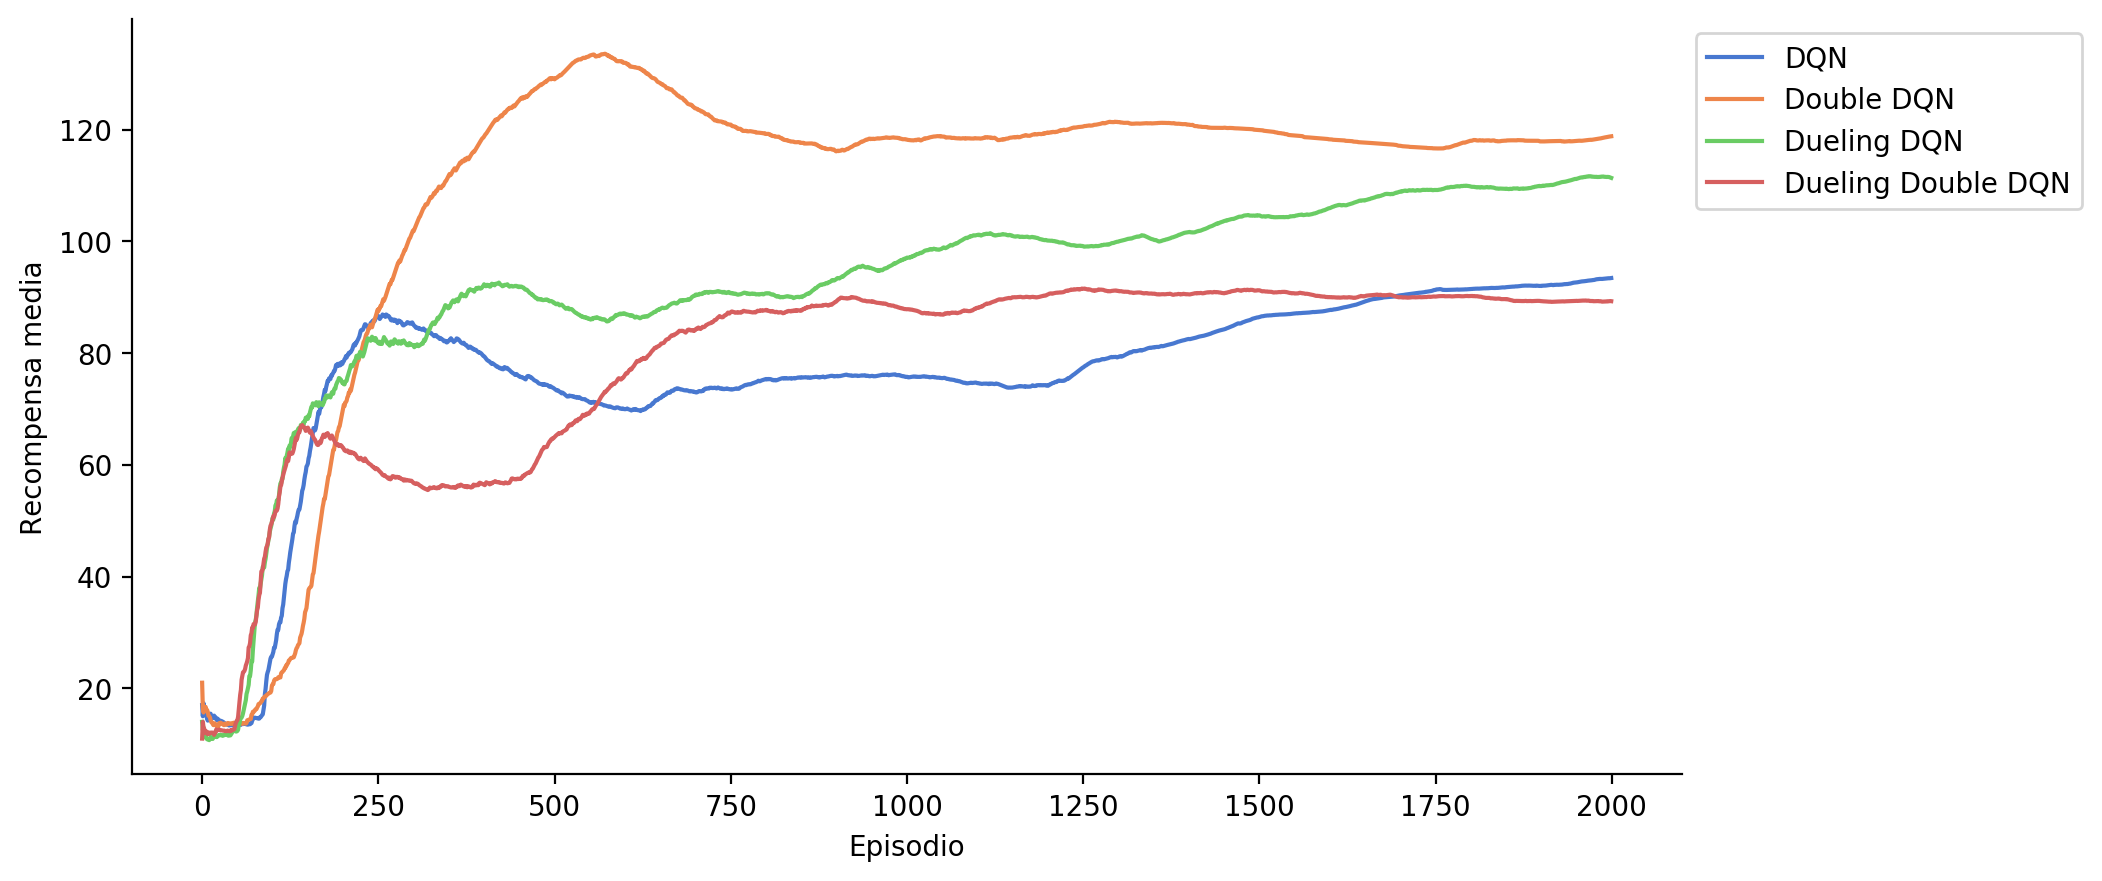

In [36]:
plt.figure(figsize=(10,5),dpi=200)
s=sns.lineplot(data=mean, dashes=False, palette="muted")
sns.despine()
s.set_xlabel("Episodio")
s.set_ylabel("Recompensa media")
plt.legend(["DQN", "Double DQN", "Dueling DQN", "Dueling Double DQN"], bbox_to_anchor=(1,1))

Para los hiperparámetros escogidos, el desempeño de las diferentes estrategias es bastante variable. Selecionamos la estrategia Dueling DQN y realizamos una búsqueda de hiperparámetros asociados a la configuración de la red (capas, neuronas, etc) para ver su impacto en el desempeño.

# Búsqueda de hiperparámetros para Dueling DQN

Realizamos un grid search de parámetros, combinando `hidden_layers = {1,2,3}`, `layer_size = {6,12,24}`, y `v_adv_layers={0,1,2}`. El parámetro `v_adv_size` se iguala a `layer_size`. No todas las combinaciones fueron ejecutadas por falta de memoria.

Por cuestion de rendimiento, los resultados se obtienen corriendo el script `dueling_dqn_search.py`, y se almacenan en el archivo `results.csv`.

In [20]:
df = pd.read_csv("results.csv")
df["unique_key"] = df.apply(lambda i : "Dueling DQN (hidden_layers:%d, layer_size:%d, adv_layers:%d)"%(i.hidden_layers, i.layer_size, i.adv_layers), axis=1)
hue_order = list(df.unique_key.unique())

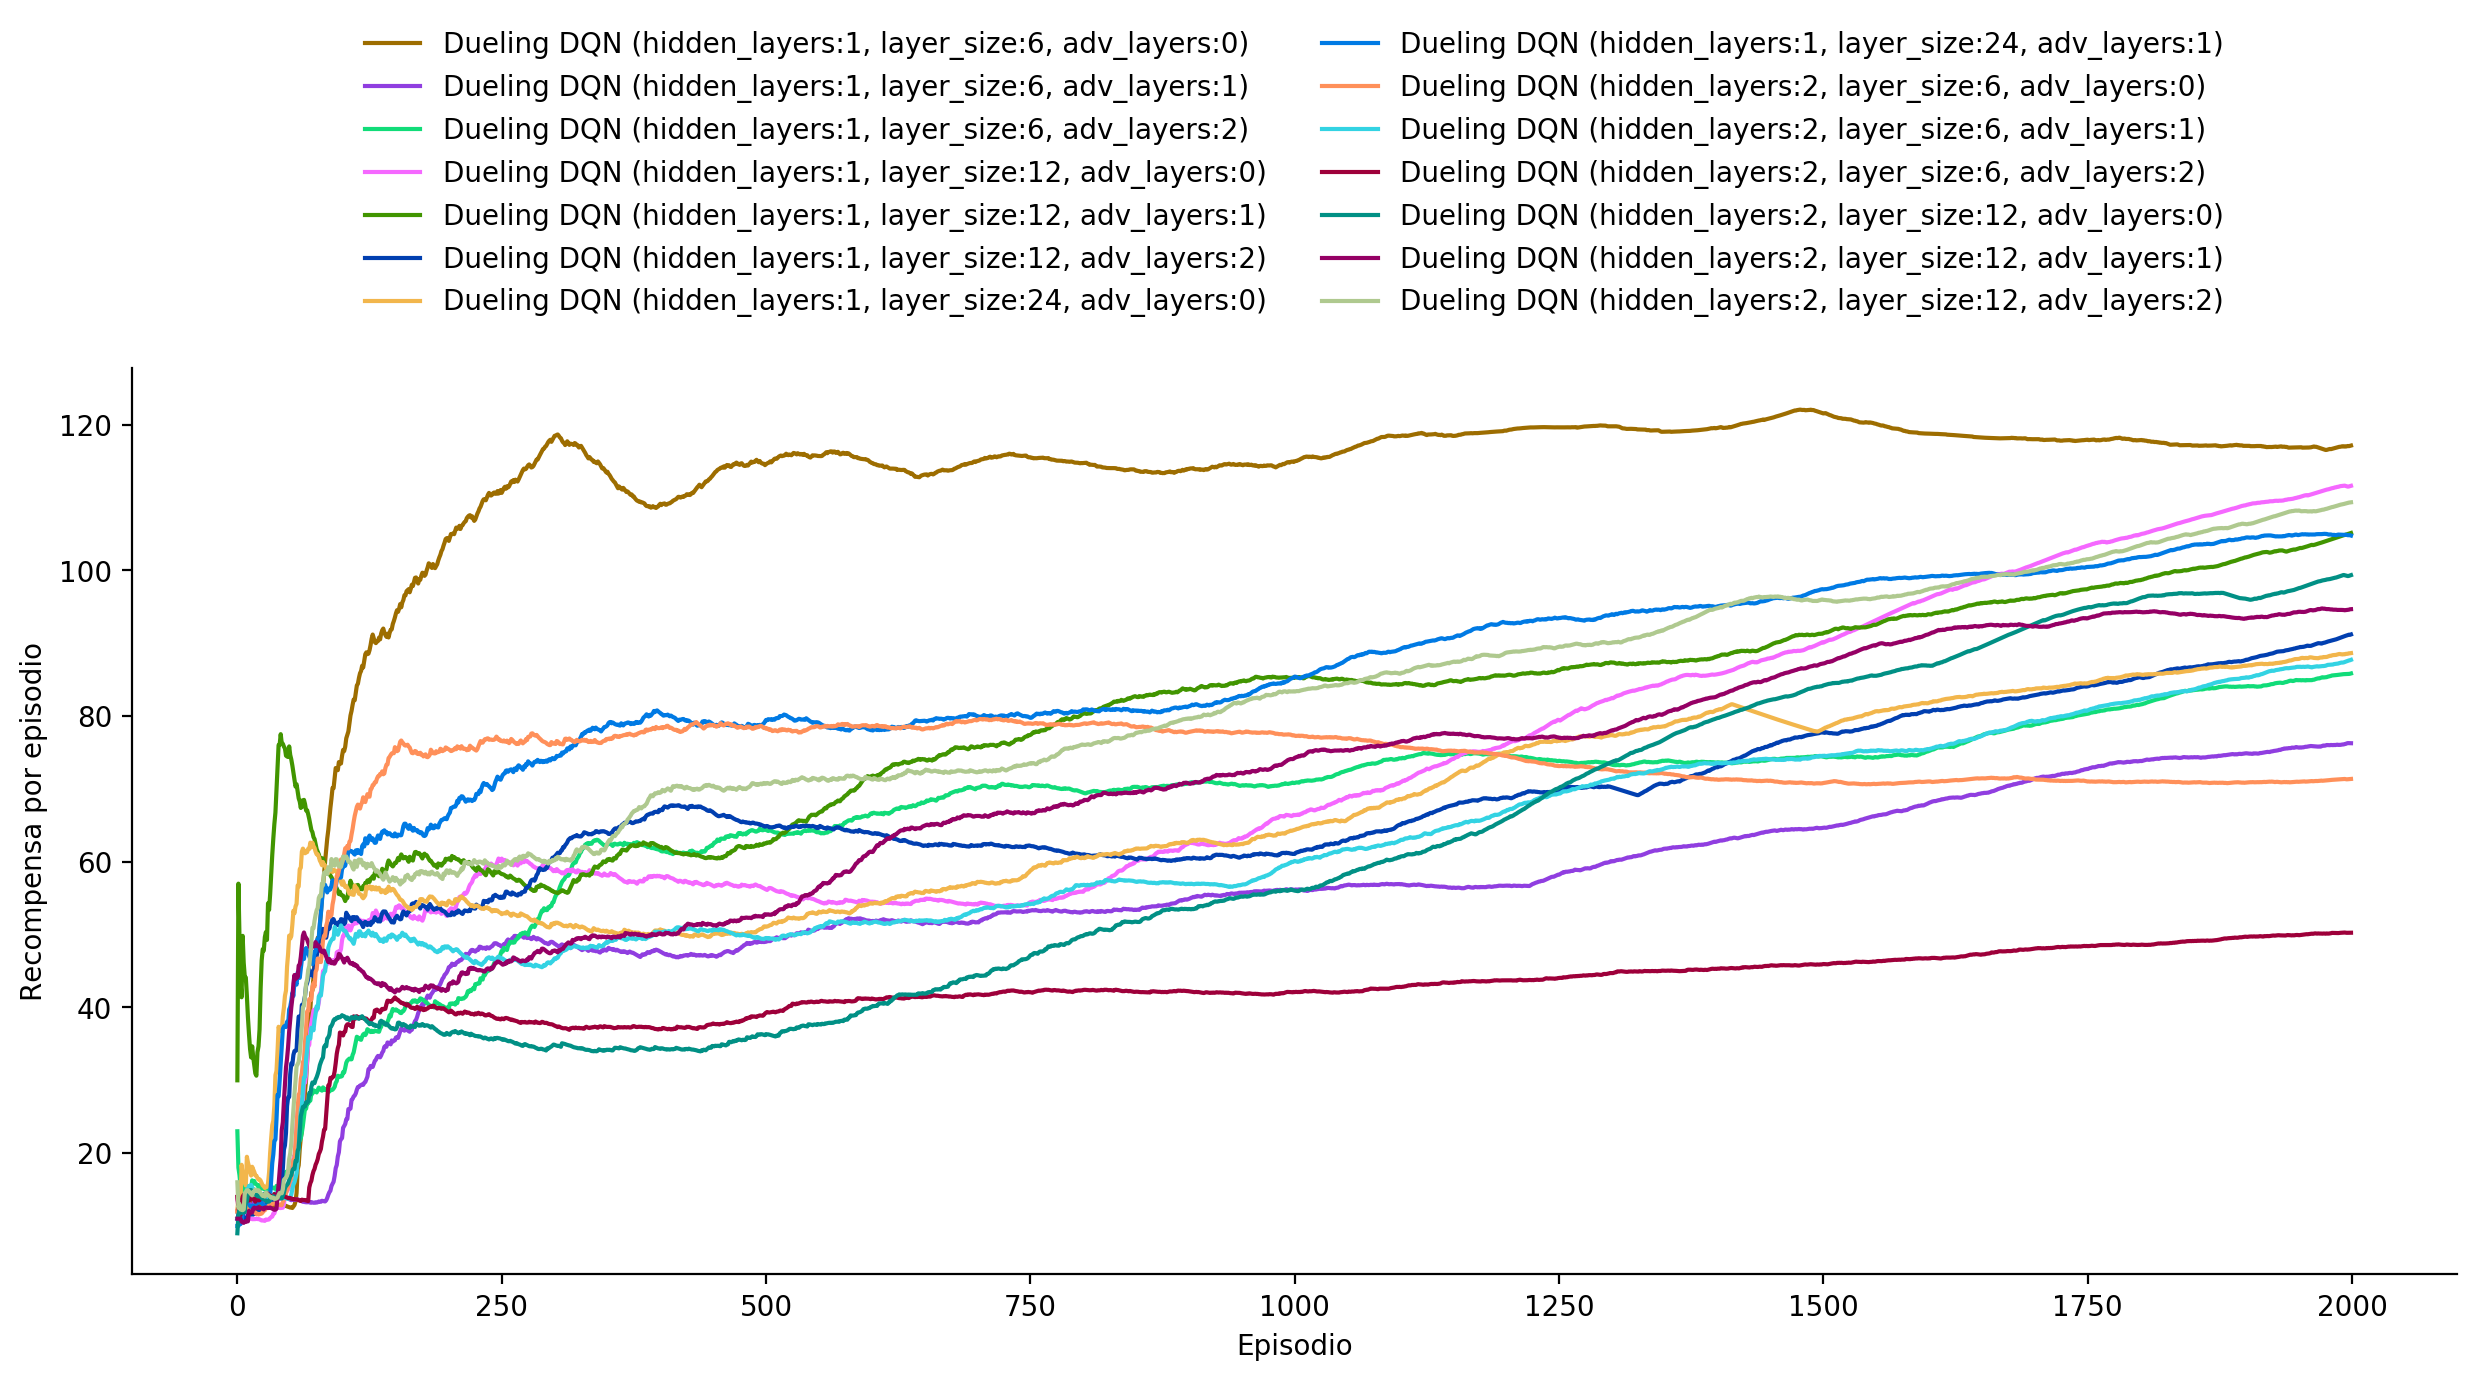

In [21]:
plt.figure(figsize=(15,6),dpi=200)
s=sns.lineplot(data=df, x="Episode", y="mean", hue="unique_key", hue_order=hue_order, dashes=False, palette=colors[:len(hue_order)])
sns.despine()
s.set_xlabel("Episodio")
s.set_ylabel("Recompensa por episodio")
plt.legend(hue_order, bbox_to_anchor=(0.5,1.4), ncol=2, title=None, frameon=False, loc=9)
plt.savefig("mean_DuelingDQN.pdf", format="pdf", bbox_inches="tight")

Veamos el detalle de las mejores ejecuciones alrededor del episodio 2000.

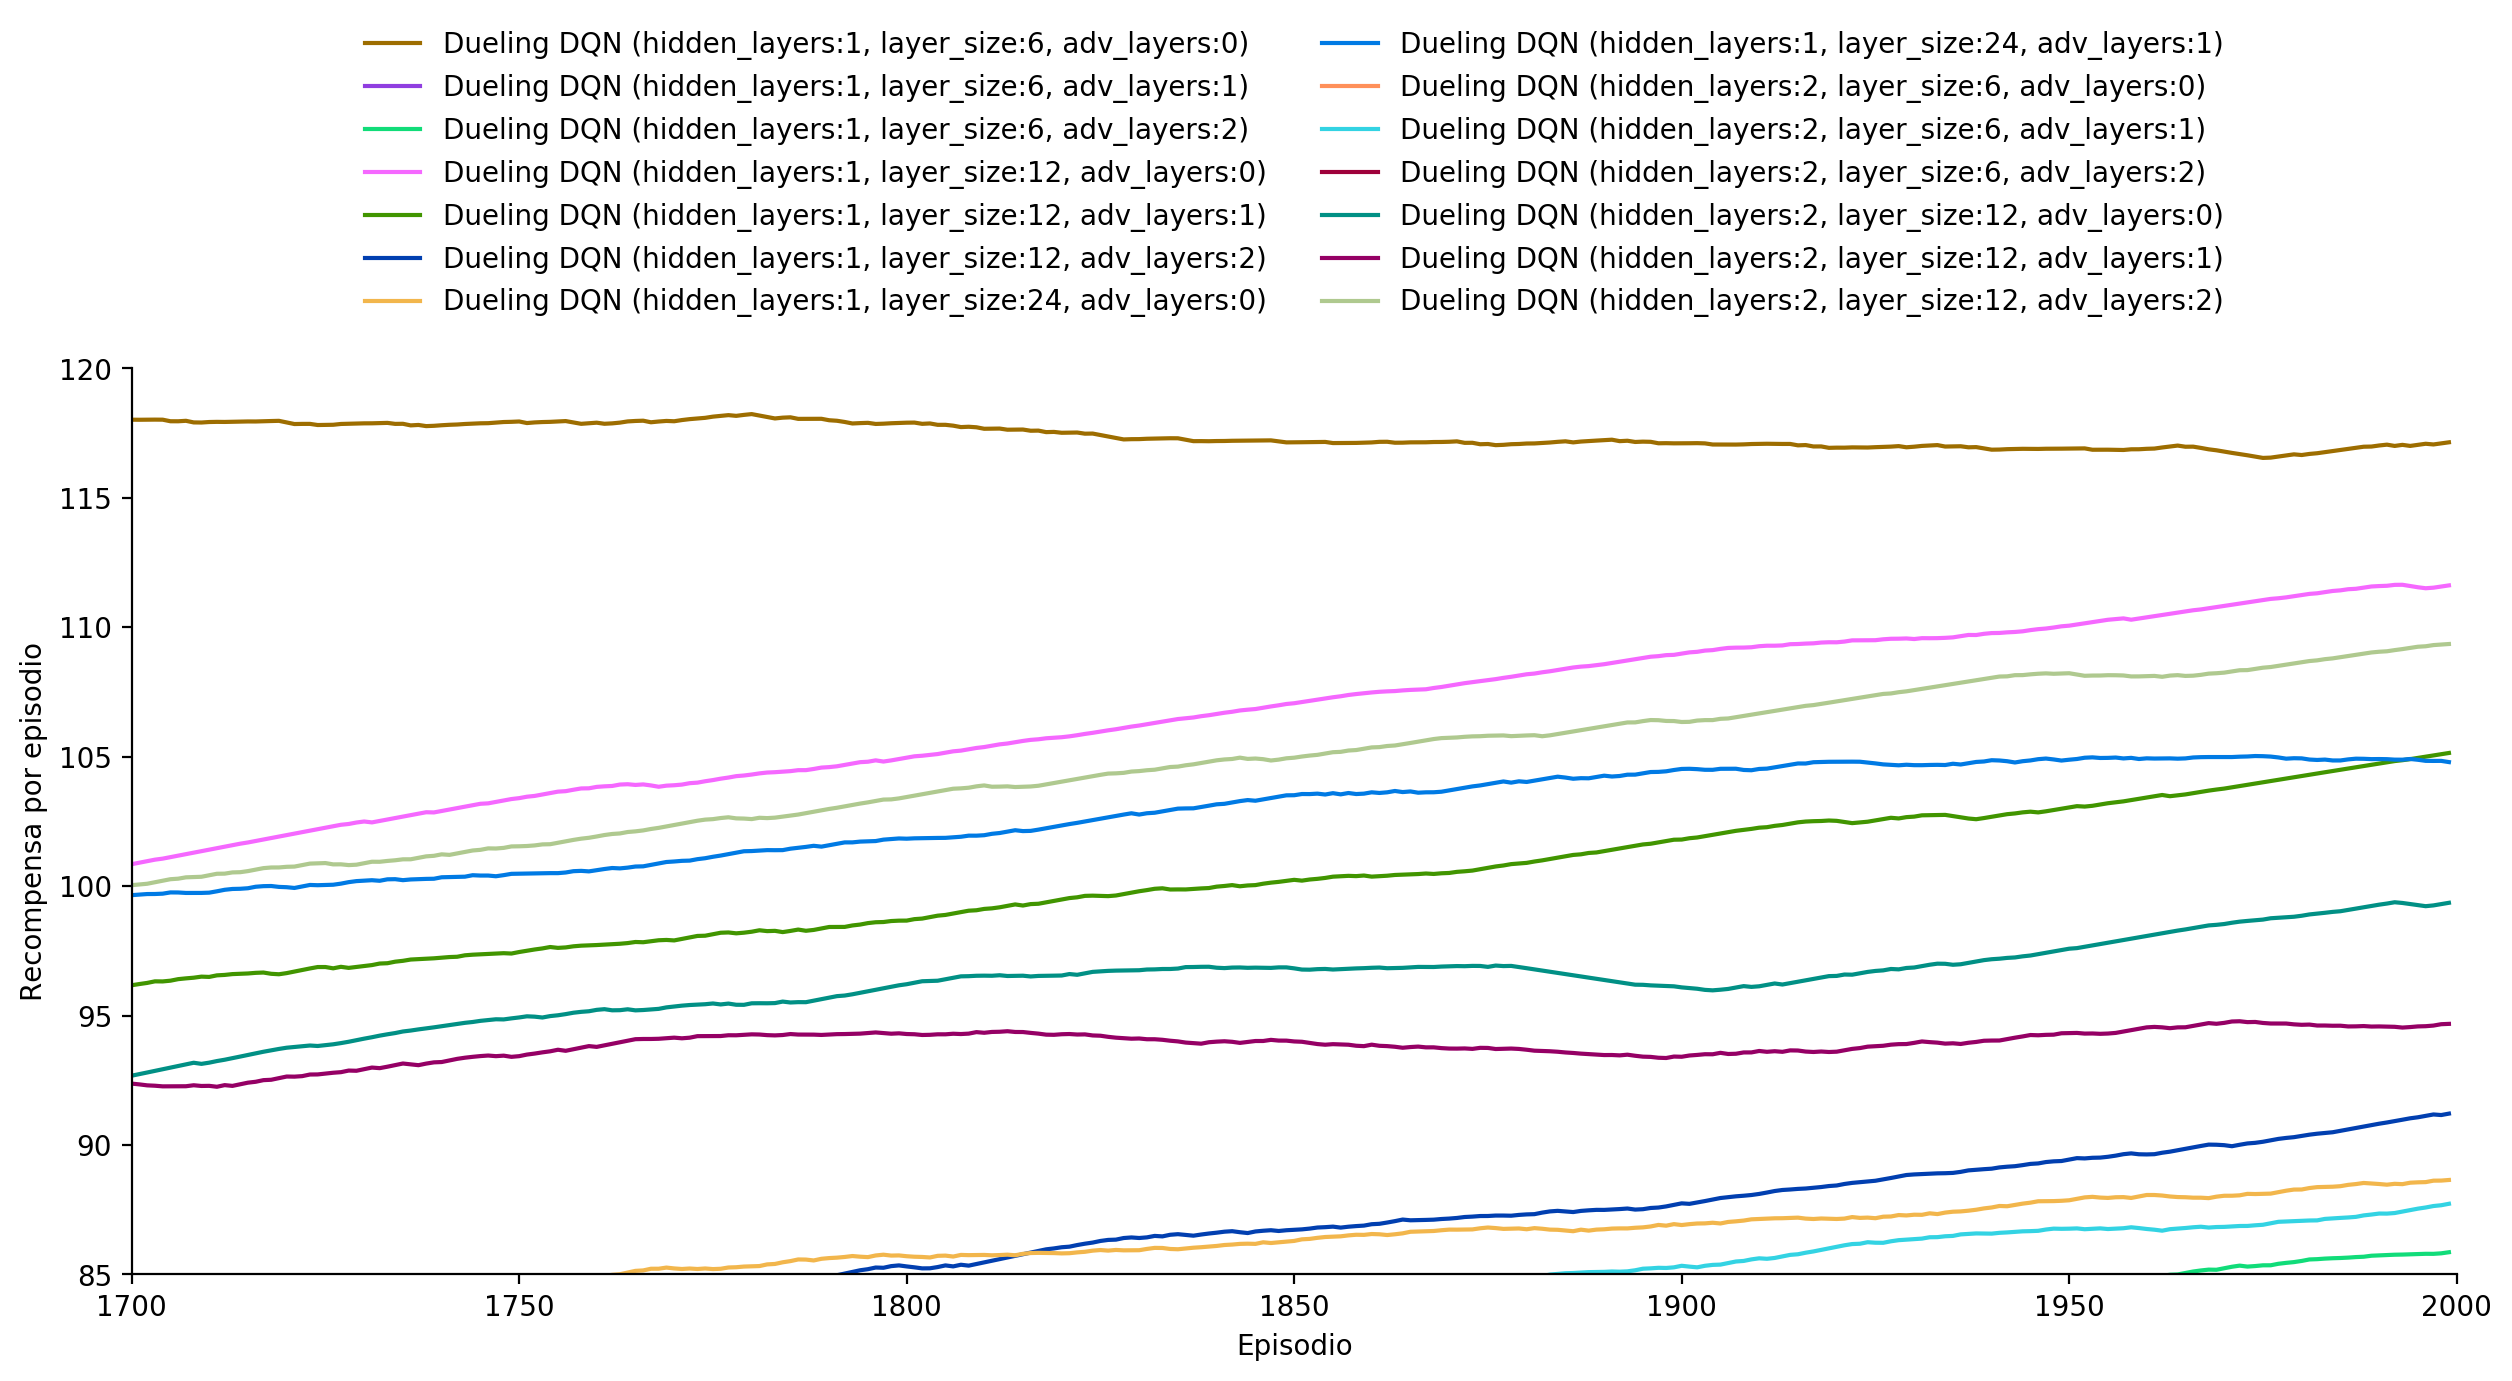

In [26]:
plt.figure(figsize=(15,6),dpi=200)
s=sns.lineplot(data=df, x="Episode", y="mean", hue="unique_key", hue_order=hue_order, dashes=False, palette=colors[:len(hue_order)])
sns.despine()
s.set_xlabel("Episodio")
s.set_ylabel("Recompensa por episodio")
s.set_ylim(85,120)
s.set_xlim(1700,2000)
plt.legend(hue_order, bbox_to_anchor=(0.5,1.4), ncol=2, title=None, frameon=False, loc=9)

# Solución de otros problemas

La resolución de otros entornos de control clásico de OpenAI Gym es elemental, ya que los modelos no dependen de particularidades del entorno.

In [ ]:
env = gym.make('Acrobot-v1')
observation_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n

model = DuelingDQN(observation_space_size, action_space_size)
target = DuelingDQN(observation_space_size, action_space_size)

agent = DQNSolver(env, model, target, double=False, n_episodes=EPISODES, debug=DEBUG)
scoresDuelingDDQN, meanDuelingDDQN = agent.run()